In [80]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

# Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [4]:
sklearn.set_config(transform_output="pandas")

In [5]:
warnings.filterwarnings("ignore")

# Read the Data

In [6]:
path = r"C:\Users\RITHIK\Flight Prices Prediction with AWS Sagemaker\Data\train.csv"

train = pd.read_csv(path)

In [7]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-27,Mumbai,Hyderabad,21:20:00,22:50:00,90,0.0,No info,2227
1,Jet Airways,2019-03-03,Delhi,Cochin,09:55:00,18:50:00,535,1.0,No info,18550
2,Jet Airways,2019-05-18,Kolkata,Banglore,16:30:00,18:15:00,1545,1.0,In-flight meal not included,10844
3,Indigo,2019-06-01,Mumbai,Hyderabad,06:25:00,07:55:00,90,0.0,No info,4049
4,Indigo,2019-03-01,Mumbai,Hyderabad,09:10:00,10:40:00,90,0.0,No info,13999
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-03,Banglore,New Delhi,05:45:00,05:05:00,1400,1.0,In-flight meal not included,11087
636,Jet Airways,2019-06-09,Delhi,Cochin,19:30:00,04:25:00,535,2.0,No info,13014
637,Multiple Carriers,2019-06-15,Delhi,Cochin,18:15:00,01:30:00,435,1.0,No info,13377
638,Jet Airways,2019-05-12,Kolkata,Banglore,09:35:00,09:45:00,1450,1.0,No info,14151


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [9]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

# Transformation Operations

In [10]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

# airline

In [11]:
X_train.airline

0                 Indigo
1            Jet Airways
2            Jet Airways
3                 Indigo
4                 Indigo
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639               Indigo
Name: airline, Length: 640, dtype: object

In [17]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with = "Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,0.0,1.0,0.0
638,0.0,0.0,1.0,0.0,0.0


# date_of_journey

In [23]:
X_train.date_of_journey

0      2019-06-27
1      2019-03-03
2      2019-05-18
3      2019-06-01
4      2019-03-01
          ...    
635    2019-03-03
636    2019-06-09
637    2019-06-15
638    2019-05-12
639    2019-06-09
Name: date_of_journey, Length: 640, dtype: object

In [33]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,1.000000,0.500000,1.000000
1,0.000000,0.000000,1.000000,0.016949
2,0.666667,0.647059,0.833333,0.661017
3,1.000000,0.764706,0.833333,0.779661
4,0.000000,0.000000,0.666667,0.000000
...,...,...,...,...
635,0.000000,0.000000,1.000000,0.016949
636,1.000000,0.823529,1.000000,0.847458
637,1.000000,0.882353,0.833333,0.898305
638,0.666667,0.588235,1.000000,0.610169


# Source ans Destination

In [37]:
X_train.source

0        Mumbai
1         Delhi
2       Kolkata
3        Mumbai
4        Mumbai
         ...   
635    Banglore
636       Delhi
637       Delhi
638     Kolkata
639       Delhi
Name: source, Length: 640, dtype: object

In [38]:
X_train.destination

0      Hyderabad
1         Cochin
2       Banglore
3      Hyderabad
4      Hyderabad
         ...    
635    New Delhi
636       Cochin
637       Cochin
638     Banglore
639       Cochin
Name: destination, Length: 640, dtype: object

In [39]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Kolkata,Banglore
3,Mumbai,Hyderabad
4,Mumbai,Hyderabad
...,...,...
635,Banglore,New Delhi
636,Delhi,Cochin
637,Delhi,Cochin
638,Kolkata,Banglore


In [45]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-1.805143,-1.041876
1,1.030725,1.030140
2,-0.152241,-0.135131
3,-1.805143,-1.041876
4,-1.805143,-1.041876
...,...,...
635,-1.018689,-1.041876
636,1.030725,1.030140
637,1.030725,1.030140
638,-0.152241,-0.135131


In [47]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [53]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,1,0
638,1,0


In [56]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.805143,-1.041876,1,0
1,1.030725,1.030140,1,0
2,-0.152241,-0.135131,1,0
3,-1.805143,-1.041876,1,0
4,-1.805143,-1.041876,1,0
...,...,...,...,...
635,-1.018689,-1.041876,0,1
636,1.030725,1.030140,1,0
637,1.030725,1.030140,1,0
638,-0.152241,-0.135131,1,0


# dep_time and arrival_time

In [60]:
X_train.dep_time

0      21:20:00
1      09:55:00
2      16:30:00
3      06:25:00
4      09:10:00
         ...   
635    05:45:00
636    19:30:00
637    18:15:00
638    09:35:00
639    16:00:00
Name: dep_time, Length: 640, dtype: object

In [61]:
X_train.arrival_time

0      22:50:00
1      18:50:00
2      18:15:00
3      07:55:00
4      10:40:00
         ...   
635    05:05:00
636    04:25:00
637    01:30:00
638    09:45:00
639    01:30:00
Name: arrival_time, Length: 640, dtype: object

In [63]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,21:20:00,22:50:00
1,09:55:00,18:50:00
2,16:30:00,18:15:00
3,06:25:00,07:55:00
4,09:10:00,10:40:00
...,...,...
635,05:45:00,05:05:00
636,19:30:00,04:25:00
637,18:15:00,01:30:00
638,09:35:00,09:45:00


In [65]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.913043,0.363636,0.956522,0.909091
1,0.391304,1.000000,0.782609,0.909091
2,0.695652,0.545455,0.782609,0.272727
3,0.260870,0.454545,0.304348,1.000000
4,0.391304,0.181818,0.434783,0.727273
...,...,...,...,...
635,0.217391,0.818182,0.217391,0.090909
636,0.826087,0.545455,0.173913,0.454545
637,0.782609,0.272727,0.043478,0.545455
638,0.391304,0.636364,0.391304,0.818182


In [68]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select([X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                                             X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                                             X_temp.loc[:, col].between(eve, night, inclusive="left")],
                                             ["morning", "afternoon", "evening"],
                                             default="night"
                                             ) for col in columns
        })
        .drop(columns = columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,night
1,morning,evening
2,evening,evening
3,morning,morning
4,morning,morning
...,...,...
635,morning,morning
636,evening,morning
637,evening,night
638,morning,morning


In [71]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.178218,0.975806
1,1.000000,0.604839
2,0.247525,0.604839
3,1.000000,1.000000
4,1.000000,1.000000
...,...,...
635,1.000000,1.000000
636,0.247525,1.000000
637,0.247525,0.975806
638,1.000000,1.000000


In [72]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.913043,0.363636,0.956522,0.909091,0.178218,0.975806
1,0.391304,1.000000,0.782609,0.909091,1.000000,0.604839
2,0.695652,0.545455,0.782609,0.272727,0.247525,0.604839
3,0.260870,0.454545,0.304348,1.000000,1.000000,1.000000
4,0.391304,0.181818,0.434783,0.727273,1.000000,1.000000
...,...,...,...,...,...,...
635,0.217391,0.818182,0.217391,0.090909,1.000000,1.000000
636,0.826087,0.545455,0.173913,0.454545,0.247525,1.000000
637,0.782609,0.272727,0.043478,0.545455,0.247525,0.975806
638,0.391304,0.636364,0.391304,0.818182,1.000000,1.000000


# Duration

In [74]:
X_train.duration

0        90
1       535
2      1545
3        90
4        90
       ... 
635    1400
636     535
637     435
638    1450
639     570
Name: duration, Length: 640, dtype: int64

In [78]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()
        
        self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}
        return self
    
    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
            objects.append(obj)
        return pd.concat(objects, axis=1)

In [79]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,1.000000,1.000000
3,0.000000e+00,0.0,0.904837,0.904837
4,0.000000e+00,0.0,0.904837,0.904837
...,...,...,...,...
635,0.000000e+00,0.0,1.000000,1.000000
636,0.000000e+00,0.0,0.904837,0.904837
637,2.457273e-77,0.0,1.000000,1.000000
638,0.000000e+00,0.0,1.000000,1.000000


In [81]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [82]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [83]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.347453,-0.126236,-0.079344,0.0,0,-1.120591
1,-0.347453,7.937143,-0.079344,2.0,0,-0.223277
2,-0.347453,-0.126236,-0.079344,2.0,1,1.813324
3,-0.347453,-0.126236,-0.079344,0.0,0,-1.120591
4,-0.347453,-0.126236,-0.079344,0.0,0,-1.120591
...,...,...,...,...,...,...
635,-0.347453,-0.126236,-0.079344,2.0,1,1.520940
636,-0.347453,7.937143,-0.079344,2.0,0,-0.223277
637,-0.347453,-0.126236,-0.079344,2.0,0,-0.424921
638,-0.347453,-0.126236,-0.079344,2.0,1,1.621762


# total_stops

In [84]:
X_train.total_stops

0      0.0
1      1.0
2      1.0
3      0.0
4      0.0
      ... 
635    1.0
636    2.0
637    1.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [85]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,1.0,0
3,0.0,1
4,0.0,1
...,...,...
635,1.0,0
636,2.0,0
637,1.0,0
638,1.0,0


# aditional_info

In [86]:

X_train.additional_info

0                          No info
1                          No info
2      In-flight meal not included
3                          No info
4                          No info
                  ...             
635    In-flight meal not included
636                        No info
637                        No info
638                        No info
639                        No info
Name: additional_info, Length: 640, dtype: object

In [87]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [88]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [89]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [90]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other,additional_info
0,0.0,1.0,0.0,1
1,0.0,1.0,0.0,1
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,1
4,0.0,1.0,0.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,1
637,0.0,1.0,0.0,1
638,0.0,1.0,0.0,1


In [91]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,-1.805143,-1.041876,1,0,0.913043,0.363636,0.956522,0.909091,0.178218,0.975806,-0.347453,-0.126236,-0.079344,0.0,0,-1.120591,0.0,1,0.0,1.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.030725,1.030140,1,0,0.391304,1.000000,0.782609,0.909091,1.000000,0.604839,-0.347453,7.937143,-0.079344,2.0,0,-0.223277,1.0,0,0.0,1.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.152241,-0.135131,1,0,0.695652,0.545455,0.782609,0.272727,0.247525,0.604839,-0.347453,-0.126236,-0.079344,2.0,1,1.813324,1.0,0,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,-1.805143,-1.041876,1,0,0.260870,0.454545,0.304348,1.000000,1.000000,1.000000,-0.347453,-0.126236,-0.079344,0.0,0,-1.120591,0.0,1,0.0,1.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.000000,-1.805143,-1.041876,1,0,0.391304,0.181818,0.434783,0.727273,1.000000,1.000000,-0.347453,-0.126236,-0.079344,0.0,0,-1.120591,0.0,1,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,-1.018689,-1.041876,0,1,0.217391,0.818182,0.217391,0.090909,1.000000,1.000000,-0.347453,-0.126236,-0.079344,2.0,1,1.520940,1.0,0,1.0,0.0,0.0,1
636,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,1.030725,1.030140,1,0,0.826087,0.545455,0.173913,0.454545,0.247525,1.000000,-0.347453,7.937143,-0.079344,2.0,0,-0.223277,2.0,0,0.0,1.0,0.0,1
637,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.833333,0.898305,1.030725,1.030140,1,0,0.782609,0.272727,0.043478,0.545455,0.247525,0.975806,-0.347453,-0.126236,-0.079344,2.0,0,-0.424921,1.0,0,0.0,1.0,0.0,1
638,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.152241,-0.135131,1,0,0.391304,0.636364,0.391304,0.818182,1.000000,1.000000,-0.347453,-0.126236,-0.079344,2.0,1,1.621762,1.0,0,0.0,1.0,0.0,1


# Feature Selection

In [92]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [93]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,1.000000,-1.805143,-1.041876,0.0,-1.120591,0.0,1
1,0.0,1.0,0.0,0.016949,1.030725,1.030140,2.0,-0.223277,1.0,0
2,0.0,1.0,0.0,0.661017,-0.152241,-0.135131,2.0,1.813324,1.0,0
3,1.0,0.0,0.0,0.779661,-1.805143,-1.041876,0.0,-1.120591,0.0,1
4,1.0,0.0,0.0,0.000000,-1.805143,-1.041876,0.0,-1.120591,0.0,1
...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.016949,-1.018689,-1.041876,2.0,1.520940,1.0,0
636,0.0,1.0,0.0,0.847458,1.030725,1.030140,2.0,-0.223277,2.0,0
637,0.0,0.0,0.0,0.898305,1.030725,1.030140,2.0,-0.424921,1.0,0
638,0.0,1.0,0.0,0.610169,-0.152241,-0.135131,2.0,1.621762,1.0,0


# Visualization

In [94]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.003454287634744572,
 'air__airline_Indigo': 0.14380465431234893,
 'air__airline_Jet Airways': 0.19687654947689137,
 'air__airline_Multiple Carriers': 0.006040464155552261,
 'air__airline_Other': 0.10444201513966045,
 'doj__date_of_journey_month': 0.07348901848848872,
 'doj__date_of_journey_week': 0.09234809206183037,
 'doj__date_of_journey_day_of_week': -0.004153808310283373,
 'doj__date_of_journey_day_of_year': 0.11948721846430677,
 'location__source': 0.15296938639820248,
 'location__destination': 0.14482352114200633,
 'location__source_is_north': 0.04639601992803988,
 'location__destination_is_north': 0.04639601992803988,
 'time__dep_time_hour': -0.028382440933253077,
 'time__dep_time_minute': -0.004459493113347072,
 'time__arrival_time_hour': 0.08440435581699084,
 'time__arrival_time_minute': -0.001345819022255686,
 'time__dep_time_part_of_day': -0.02875479639114949,
 'time__arrival_time_part_of_day': 0.03425271756202064,
 'dur__duration_rbf_25': 0.082

In [95]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': -0.02875479639114949,
 'time__dep_time_hour': -0.028382440933253077,
 'dur__duration_rbf_75': -0.0075702831714929975,
 'time__dep_time_minute': -0.004459493113347072,
 'doj__date_of_journey_day_of_week': -0.004153808310283373,
 'info__additional_info_No info': -0.0038021025967593935,
 'info__additional_info': -0.003773647974805616,
 'air__airline_Air India': -0.003454287634744572,
 'time__arrival_time_minute': -0.001345819022255686,
 'info__additional_info_In-flight meal not included': 0.000116610691689778,
 'dur__duration_rbf_50': 0.005329834243300839,
 'air__airline_Multiple Carriers': 0.006040464155552261,
 'time__arrival_time_part_of_day': 0.03425271756202064,
 'info__additional_info_Other': 0.035615616835046694,
 'location__source_is_north': 0.04639601992803988,
 'location__destination_is_north': 0.04639601992803988,
 'doj__date_of_journey_month': 0.07348901848848872,
 'dur__duration_over_1000': 0.07918809210234985,
 'dur__duration_rbf_25': 0.0822705

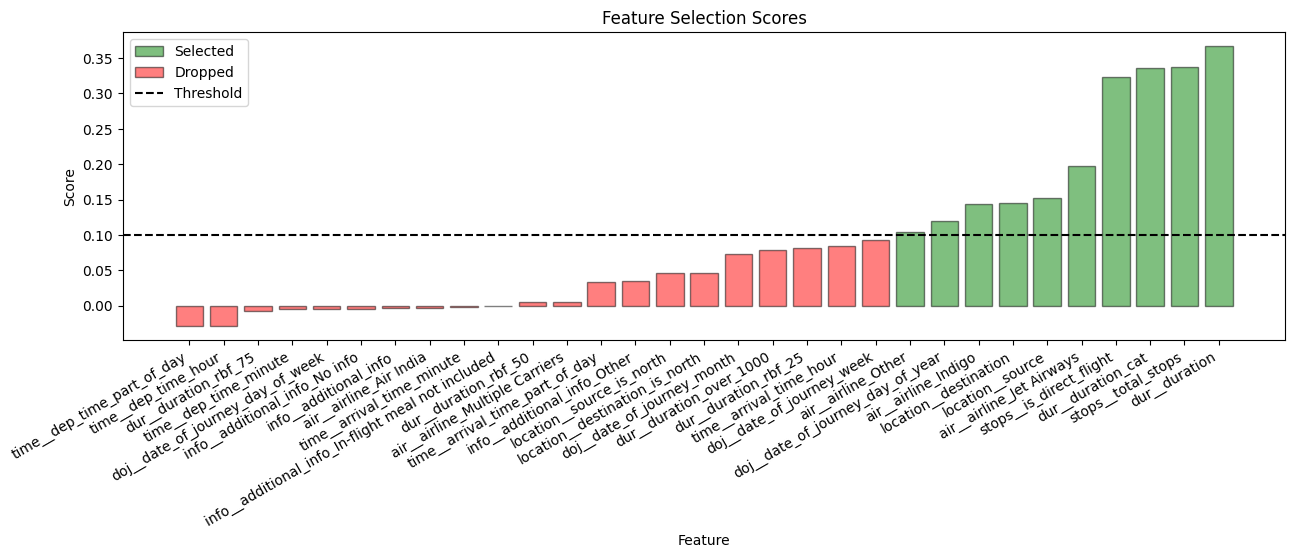

In [96]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()